In [2]:
import pandas as pd
import numpy as np
import calculate_cleavage_rate as clv
%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()
reload(clv)
import sys
import Nucleaseq_data_processing as processing
reload(processing)
import read_model_ID as model
reload(model)
guide = 20

In [3]:
filename = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
xdata, ydata, yerr = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data)
_, ydatawa, yerrwa = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,True,False,False,False)
#_, ydatamedian, yerrmedian = processing.prepare_multiprocessing_nucleaseq(filename, path_to_data, True)
_, ydatalog, yerrlog = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,True,False,True,False)

datacompclv = []
datacompon = []
pos = []
kclv = []
kon = []

i = 1
while i < guide+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            pos.append(xdata[a][0])
            kclv.append(ydatawa[a][0][0])
            kon.append(ydatawa[a][1][0])
            datacompclv.append(ydata[a][0])
            datacompon.append(ydata[a][1])
            
            i = i + 1
    
pos.append(21)
kclv.append(ydatawa[0][0][0])
kon.append(ydatawa[0][1][0])
datacompclv.append(ydata[0][0])
datacompon.append(ydata[0][1])


pos = np.array(pos)
kclv = np.array(kclv)
kon = np.array(kon)

3.0190848759998066e-05
3.0227987737424567e-05
3.0231941790260496e-05
3.0526357893185986e-05
4.085691793639828e-06


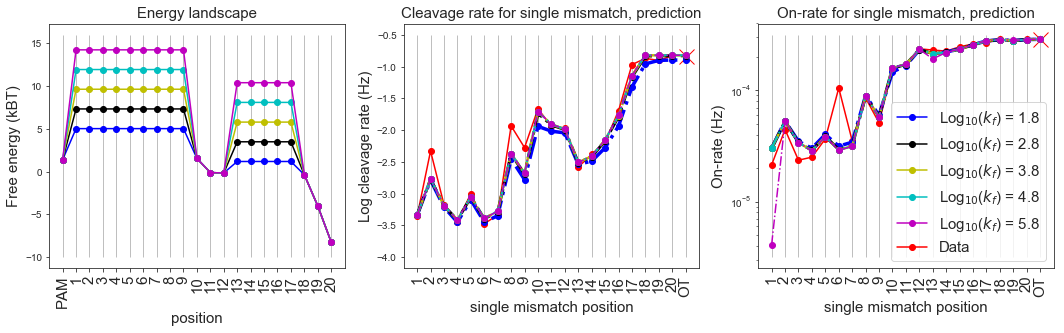

In [6]:
legend = False
f,ax = plt.subplots(1,3,sharey=False,figsize=[18.,4.5])
colour = ['b','k','y','c','m','g','slateblue']

model_ID = 'Clv_Saturated_edit_boyle_landscape_flat+On_edit_boyle_landscape_flat'; parnum = '25'
filename = 'fit_17_5_2019_sim_2.txt'
path = '../fits_Stijn/17_5_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
parameters = np.array(final_par.values)

plot2, = ax[1].plot(range(1,21),kclv[0:20],marker='o',color='r',label='Weighted average')
plot3 = ax[1].plot(21,kclv[20],marker='x',color='r',markersize=15,label='On-target')
if legend:
    ax[1].legend(handles=[plot1[0],plot2[0],plot3[0],plot4[0]],loc='center left',bbox_to_anchor=(1,0.5),fontsize=15)
ax[1].set_xlabel('single mismatch position', fontsize=15)
ax[1].set_ylabel('Log cleavage rate (Hz)', fontsize=15)
ax[1].set_title('Cleavage rate for single mismatch, prediction', fontsize=15)
ax[1].set_xticks(range(1,22));
ax[1].set_xticklabels(range(1,21)+['OT'],fontsize=15,rotation='vertical')
ax[1].vlines(range(1,22),-4,-0.5,color='grey',linewidth=0.5);
#plt.axis([0,22,-7,0]);

plot2, = ax[2].plot(range(1,21),kon[0:20],marker='o',color='r',label='Data')
plot3 = ax[2].plot(21,kon[20],marker='x',color='r',markersize=15,label='On-target')
if legend:
    ax[2].legend(handles=[plot1[0],plot2[0],plot3[0],plot4[0]],loc='center left',bbox_to_anchor=(1,0.5),fontsize=15)
ax[2].set_xlabel('single mismatch position', fontsize=15)
ax[2].set_ylabel('On-rate (Hz)', fontsize=15)
ax[2].set_title('On-rate for single mismatch, prediction', fontsize=15)
ax[2].set_xticks(range(1,22));
ax[2].set_xticklabels(range(1,21)+['OT'],fontsize=15,rotation='vertical')
ax[2].vlines(range(1,22),10**-5.5,10**-3.5,color='grey',linewidth=0.5);
#ax[0][1].axis([0,22,10**-1.5,10**0])

ax[0].set_xlabel('position',fontsize=15)
ax[0].set_ylabel('Free energy (kBT)',fontsize=15)
ax[0].set_title('Energy landscape',fontsize=15)
ax[0].vlines(range(0,21),-10,16,color='grey',linewidth=0.5);
ax[0].set_xticks(range(0,21));
ax[0].set_xticklabels(['PAM'] + range(1,21),fontsize=15,rotation='vertical')

c = [0.1,1.,10.,100.,1000.]
landscape = []

for m in range(len(c)):
    parameters_temp = parameters.copy()
    parameters_temp[0] += np.log(c[m])
    parameters_temp[1] += np.log(c[m])
    parameters_temp[-2] += np.log10(c[m])

    k = np.zeros(21)
    on = np.zeros(21)

    for i in range(1,guide+1):
        mismatch = [i]
        k[i-1],on[i-1] = clv.calc_clv_on(parameters_temp,model_ID,mismatch,guide)

    k[-1],on[-1] = clv.calc_clv_on(parameters_temp,model_ID,[],guide)

    print on[0]
    plot4 = ax[1].plot(range(1,22),np.log10(k),color=colour[m],marker='o',label='Predicted kclv',linewidth=3.5-m*0.5,linestyle = '-.')
    plot4 = ax[2].semilogy(range(1,22),on,marker='o',color=colour[m],label='Predicted on-rate',linewidth=3.5-m*0.5,linestyle = '-.')
    
    model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(parameters_temp,model_ID)
    energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
    energies[0] *= -1.
    
    landscapem = ax[0].plot(range(0,21),-np.cumsum(energies[0:21]),marker = 'o',color=colour[m],linewidth=1.5,label='Log$_{10}$($k_f$) = ' + str(np.round(parameters_temp[-2],1)))
    landscape.append(landscapem[0])
landscape.append(plot2)    
ax[2].legend(handles=landscape,fontsize=15)

In [100]:
m = 4

parameters_temp = parameters.copy()
parameters_temp[0] += np.log(c[m])
parameters_temp[1] += np.log(c[m])
parameters_temp[-2] += np.log10(c[m])


_,model_on,_,parameters_on = model.combined_model(parameters_temp,model_ID)
epsilon, forward_rates = model.unpack_parameters(parameters_on,model_on)
energies = clv.get_energies(epsilon,[1])
backward_rates = clv.get_backward_rates(energies,forward_rates)
matrix = clv.get_master_equation(parameters_on,[1],model_on,20)
#print matrix


print clv.get_backward_rates(energies,forward_rates)

[0.00000000e+00 1.57877038e-02 8.20349948e+13 5.86160558e+05
 5.86160558e+05 5.86160558e+05 5.86160558e+05 5.86160558e+05
 5.86160558e+05 5.86160558e+05 5.86160558e+05 1.79743956e+00
 1.12267088e+05 5.58669879e+05 2.24603097e+10 5.86160558e+05
 5.86160558e+05 5.86160558e+05 5.86160558e+05 1.24250857e+01
 1.52639791e+04 8.66527572e+03]
